In [20]:
from get_models import Progress_Bar, Encoder, Decoder, CovarianceMatrix, thermometer_encode_df

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.normal import Normal
import scipy.stats as stats
from scipy.stats import chi2
from torchmin import minimize
from torch.distributions.multivariate_normal import MultivariateNormal

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
#Load dataframes: test_scores has high dimensional test score data of hfsme tests
test_scores_df = pd.read_csv(os.getcwd()+'/test_scores.csv')

#test_scores_df_encoded is a thermometer encoding of test_scores_df for the encoder network
test_scores_df_encoded = thermometer_encode_df(test_scores_df, test_scores_df.columns[1:])

#time_df contains data that changes with time, e.g.: age or time since medication switch
time_df = pd.read_csv(os.getcwd()+'/time_df.csv')
time_df['intercept'] = np.ones(time_df.shape[0])

#baseline_df contains features that characterizes patients at baseline
baseline_df = pd.read_csv(os.getcwd()+'/baseline_df.csv')

# 'sex' has no influence:
baseline_df['sex'] = np.random.randint(2, size=baseline_df.shape[0])

df_effects = pd.merge(baseline_df, time_df, on='patient_id', how='inner')

fixed_effects_keys = ['family_affected', 'sco_surg', '≤3', 'onset_age', 'presym_diag', 'presymptomatic', 'stand_lost', 'stand_gained', 'stand_never', 'sex']
random_effects_keys = ['intercept', 'since_medication', 'since_switch']

p = len(fixed_effects_keys)
q = len(random_effects_keys)

#vae latent dimension
latent_dim = 2

def get_ind(id, df):
    return np.where(df['patient_id'] == id)[0]

def get_design_matrix(df_effects, fixed_effects_keys, random_effects_keys, r=1, include_interaction=False):
    patient_id = df_effects['patient_id'].unique()

    X_list = [torch.from_numpy(np.array(df_effects.loc[get_ind(id, df_effects), fixed_effects_keys])).to(torch.float32) for id in patient_id]

    if include_interaction==True:
        for key in random_effects_keys[1:]:
            X_list = [torch.cat((X_i, X_i[:,1:] * torch.from_numpy(np.array(df_effects.loc[get_ind(patient_id[j], df_effects), key])).unsqueeze(-1)
                                ), -1).to(torch.float32) for j,X_i in enumerate(X_list)]

    X_list = [torch.cat((torch.from_numpy(np.array(df_effects.loc[get_ind(patient_id[j], df_effects), 'age'])).unsqueeze(-1), X_i), -1).to(torch.float32) for j,X_i in enumerate(X_list)]


    Z_list = [torch.from_numpy(np.array(df_effects.loc[get_ind(id, df_effects), random_effects_keys])).to(torch.float32) for id in patient_id]
    Z_list = [torch.block_diag(*[i for j in range(r)]) for i in Z_list]   
    X_list = [torch.block_diag(*[i for j in range(r)]) for i in X_list]
    return X_list, Z_list



In [47]:
latent_dim =  1
X_list, Z_list = get_design_matrix(df_effects, fixed_effects_keys, random_effects_keys, r=latent_dim, include_interaction=False)
pat_ind = np.cumsum([0]+[int(len(X_i)/latent_dim) for X_i in X_list])

In [48]:
# initialize Encoder and Decoder Models and the Mixed Model Parameters. mode='diagonal': Diagonal Covariance Matrix, mode='full': Full Covariance Matrix,
def initialize(latent_dim, mode='diagonal'):
    encoder = Encoder(
        input_dim=np.shape(test_scores_df_encoded)[-1],
        hidden_dims=[150], 
        output_dim=latent_dim, 
        act=torch.nn.Tanh())

    decoder = Decoder(
        item_positions=np.concatenate([[i]*a for i,a in enumerate(np.array(test_scores_df[test_scores_df.columns[1:]].max(0)).astype(np.int32))]),                            
        input_dim=latent_dim,
        hidden_dims=[150], 
        act=torch.nn.Tanh())

    var_param = CovarianceMatrix(q*latent_dim, mode=mode)    
    return encoder, decoder, var_param

In [96]:
patients = torch.from_numpy(np.array(baseline_df['patient_id']))
num_patients = len(patients)

#Train the VAE model:  Weighting of the loss function
# alpha: kl-divergence weight;  
# delta: MSE distance between encoder prediction and decoder; 
# gamma: decoder reconstruction loss
# eta: mixed model loss

# batch_size should be greater than 50
def train_vae(epochs, batch_size, X_list, Z_list, encoder, decoder, var_param, optimizer_vae, alpha=1, gamma=1, delta=0, eta=0):
    steps = int(num_patients / batch_size)
    rng = np.random.default_rng(1234)
    prior = Normal(torch.zeros(torch.Size([latent_dim])), torch.ones(torch.Size([latent_dim])))
    progBar = Progress_Bar(epochs, steps, ['nELBO', 'KL', 'nML', 'Rec Loss', 'Residuals', 'Item Error'])

    
    for epoch in range(epochs):
        shuffle = rng.permutation(num_patients)
        
        for step in range(steps):
            #draw minibatch
            pat_batch = patients[shuffle[step*batch_size:(step+1)*batch_size]]
            pat_ind_batch = [torch.arange(pat_ind[i],pat_ind[i+1]) for i in pat_batch]
            
            ind_batch = []
            add = 0
            for ind in range(len(pat_ind_batch)):
                len_i = len(pat_ind_batch[ind])
                ind_batch += [torch.arange(add, add + len_i)]
                add += len_i

            Z_list_batch = [Z_list[pat] for pat in pat_batch]
            X_list_batch = [X_list[pat] for pat in pat_batch]
            
            # warum nicht torch.cat statt concatenate
            test_data = torch.concatenate([torch.from_numpy(np.array(test_scores_df_encoded.loc[ind])).to(torch.float32) for ind in pat_ind_batch])
            test_data_orig = torch.concatenate([torch.from_numpy(np.array(test_scores_df[test_scores_df.columns[1:]].loc[ind])).to(torch.int32) for ind in pat_ind_batch])
            
            optimizer_vae.zero_grad(set_to_none=True)
            #encode test scores
            mu, log_sig = encoder.encode(test_data)

            #reparametrization trick to get latent variables
            eps = prior.sample(torch.Size([log_sig.size(dim=0)]))
            z = mu + log_sig.exp() * eps
            
            #kl divergence
            kl = torch.mean(0.5 * torch.sum(mu.square() + torch.exp(2.0 * log_sig) - 1.0 - (2.0 * log_sig), dim=1))

            # get the response variable list (latent z)
            z_list = [z[ind].flatten().to(torch.float32) for ind in ind_batch]

            #Mixed model loglikelihood loss. Notation follows https://www.sfu.ca/sasdoc/sashtml/stat/chap41/sect23.htm
            Phi, sigma = var_param()
            N = sum([len(Z_i) for Z_i in Z_list_batch])

            V_list = [Z_i @ Phi @ Z_i.t() + torch.eye(Z_i.size(0)) * sigma for Z_i in Z_list_batch]
            V_inv_list = [V_i.inverse() for V_i in V_list]
            
            Xt_V_inv_X = torch.stack([X_i.t() @ V_i_inv @ X_i for X_i, V_i_inv in zip(X_list_batch, V_inv_list)]).sum(dim=0)
            Xt_V_inv_y = torch.stack([X_i.t() @ V_i_inv @ y_i for X_i, V_i_inv, y_i in zip(X_list_batch, V_inv_list, z_list)]).sum(dim=0)

            #Check if Xt_V_inv_X is invertible. Only needed for mini batching
            if torch.abs(torch.det(Xt_V_inv_X)) > 1e-6:
                EBLUE = Xt_V_inv_X.inverse() @ Xt_V_inv_y
                EBLUP_list = [Phi @ Z_i.t() @ V_i_inv @ (y_i - X_i @ EBLUE) for X_i, Z_i, V_i_inv, y_i in zip(X_list_batch, Z_list_batch, V_inv_list, z_list)]

                residual_list = [y_i - X_i @ EBLUE for y_i, X_i in zip(z_list, X_list_batch)]
                #Mixed model prediction
                z_pred = torch.cat([X_i @ EBLUE + Z_i @ EBLUP_i for X_i, Z_i, EBLUP_i in zip(X_list_batch, Z_list_batch, EBLUP_list)]).reshape((-1, latent_dim))

                log_det_V = torch.stack([V_i.det().clamp(min=1e-12).log() for V_i in V_list]).sum()
                const = torch.log(torch.tensor(2.0 * torch.pi))
                rt_V_inv_r = torch.stack([r_i.t() @ V_i_inv @ r_i for r_i, V_i_inv in zip(residual_list, V_inv_list)]).sum()

                #negative mixed models likelihood
                nML = 0.5 * (log_det_V + rt_V_inv_r + N * const) / N
                
                #distance between encoder latent variables and mixed model prediction
                residuals = ((z_pred - z) ** 2).sum(1).mean()

                #reconstruction loss
                rec_loss, probs = decoder(z, test_data_orig)
                nelbo = alpha * kl + delta * residuals + gamma * rec_loss + eta * nML
                
                nelbo.backward()
                optimizer_vae.step()

                data_pred = torch.stack([torch.argmax(pred, dim=-1) for pred in probs]) 
                # total test item prediction error  
                item_error = np.mean(np.sum(np.abs(data_pred.detach().numpy() - test_data_orig.T.numpy()), axis=0))

                progBar.update({
                    'nELBO': nelbo.item(), 
                    'KL': alpha * kl.item(), 
                    'nML': eta * nML.item(),
                    'Rec Loss': gamma * rec_loss.item(), 
                    'Residuals': delta * residuals.item(),
                    'Item Error': item_error,
                    }) 
            
#train_vae(300, 60,X_list, Z_list, encoder, decoder, var_param, optimizer_vae, alpha=1, gamma=1, delta=1, eta=1)  
# get the model prediction:
def eval_vae(X_list, Z_list, var_param, encoder):
    with torch.no_grad():
        pat_ind_batch = [torch.arange(pat_ind[i],pat_ind[i+1]) for i in patients]
        prior = Normal(torch.zeros(torch.Size([latent_dim])), torch.ones(torch.Size([latent_dim])))

        test_data = torch.concatenate([torch.from_numpy(np.array(test_scores_df_encoded.loc[ind])).to(torch.float32) for ind in pat_ind_batch])

        mu, log_sig = encoder.encode(test_data)

        eps = prior.sample(torch.Size([log_sig.size(dim=0)])) 
        z = mu + log_sig.exp() * eps # latent data

        z_list = [z[ind].flatten().to(torch.float32) for ind in pat_ind_batch]

        Phi, sigma = var_param()
        N = sum([len(Z_i) for Z_i in Z_list])

        V_list = [Z_i @ Phi @ Z_i.t() + torch.eye(Z_i.size(0)) * sigma for Z_i in Z_list]
        V_inv_list = [V_i.inverse() for V_i in V_list]
        
        Xt_V_inv_X = torch.stack([X_i.t() @ V_i_inv @ X_i for X_i, V_i_inv in zip(X_list, V_inv_list)]).sum(dim=0)
        Xt_V_inv_y = torch.stack([X_i.t() @ V_i_inv @ y_i for X_i, V_i_inv, y_i in zip(X_list, V_inv_list, z_list)]).sum(dim=0)

        EBLUE = Xt_V_inv_X.inverse() @ Xt_V_inv_y
        EBLUP_list = [Phi @ Z_i.t() @ V_i_inv @ (y_i - X_i @ EBLUE) for X_i, Z_i, V_i_inv, y_i in zip(X_list, Z_list, V_inv_list, z_list)]

        residual_list = [y_i - X_i @ EBLUE for y_i, X_i in zip(z_list, X_list)]
        z_pred = torch.cat([X_i @ EBLUE + Z_i @ EBLUP_i for X_i, Z_i, EBLUP_i in zip(X_list, Z_list, EBLUP_list)]).reshape((-1, latent_dim))

        log_det_V = torch.stack([V_i.det().clamp(min=1e-12).log() for V_i in V_list]).sum()
        const = torch.log(torch.tensor(2.0 * torch.pi))
        rt_V_inv_r = torch.stack([r_i.t() @ V_i_inv @ r_i for r_i, V_i_inv in zip(residual_list, V_inv_list)]).sum()

        nML = 0.5 * (log_det_V + rt_V_inv_r + N * const) 
        return mu, z, z_pred, nML
    
# mu, z, z_pred, nML = eval_vae(X_list, Z_list, var_param, encoder)

In [109]:
def likelihood_ratio(L_full, L_red):
    return 2 * (L_full - L_red)

# returns a block diagonal matrix of a list of matrices
def block_diag_list(arrs_list):
    shape = torch.sum(torch.tensor([a.shape for a in arrs_list], dtype=torch.int32), dim=0)
    dtype = arrs_list[0].dtype
    device = arrs_list[0].device

    out = torch.zeros(*shape.tolist(), dtype=dtype, device=device)

    r, c = 0, 0
    for a in arrs_list:
        rows, cols = a.shape
        out[r:r + rows, c:c + cols] = a
        r += rows
        c += cols
    return out


def calc_mmloss(var_param, X_list, Z_list, y_list, calc_reml=False):
    Phi, sigma = var_param()
    N = sum([len(Z_i) for Z_i in Z_list])

    V_list = [Z_i @ Phi @ Z_i.t() + torch.eye(Z_i.size(0)) * sigma for Z_i in Z_list]
    V_inv_list = [V_i.inverse() for V_i in V_list]

    Xt_V_inv_X = torch.stack([X_i.t() @ V_i_inv @ X_i for X_i, V_i_inv in zip(X_list, V_inv_list)]).sum(dim=0)
    Xt_V_inv_y = torch.stack([X_i.t() @ V_i_inv @ y_i for X_i, V_i_inv, y_i in zip(X_list, V_inv_list, y_list)]).sum(dim=0)

    N = sum([len(Z_i) for Z_i in Z_list])

    EBLUE = Xt_V_inv_X.inverse() @ Xt_V_inv_y
    EBLUP_list = [Phi @ Z_i.t() @ V_i_inv @ (y_i - X_i @ EBLUE) for X_i, Z_i, V_i_inv, y_i in zip(X_list, Z_list, V_inv_list, y_list)]

    residual_list = [y_i - X_i @ EBLUE for y_i, X_i in zip(y_list, X_list)]

    log_det_V = torch.stack([V_i.det().clamp(min=1e-12).log() for V_i in V_list]).sum()
    const = torch.log(torch.tensor(2.0 * torch.pi))
    rt_V_inv_r = torch.stack([r_i.t() @ V_i_inv @ r_i for r_i, V_i_inv in zip(residual_list, V_inv_list)]).sum()

    # #negative mixed models likelihood
    nML = 0.5 * (log_det_V + rt_V_inv_r + N * const) / N

    if calc_reml:
        p = Xt_V_inv_X.size(0)
        reml = nML + 0.5 * p * const / N
        return nML, reml

    return nML

def train_mixed_model(var_param, X_list, Z_list, y_list, learning_rate=0.01, epochs=100):
    optimizer = torch.optim.Adam(var_param.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        optimizer.zero_grad()

        nML = calc_mmloss(var_param, X_list, Z_list, y_list)
        nML.backward()

        optimizer.step()

    return var_param

In [51]:

encoder, decoder, var_param = initialize(latent_dim, mode='diagonal')
optimizer_vae = torch.optim.Adam([
    #{'params': var_param.parameters(), 'lr': 0.1},  
    {'params': encoder.parameters(), 'lr': 0.01},  
    {'params': decoder.parameters(), 'lr': 0.01},  
]) 
train_vae(200,60, X_list, Z_list, encoder, decoder, var_param, optimizer_vae, delta=0, eta=0)
latent_rep = eval_vae(X_list, Z_list, var_param, encoder)[1].clone().detach().float()
latent_data = latent_rep.flatten()


Progress: 77.0% - ETA: 0:01:43 - Epoch: 154 - Iteration: 616 - ms/Iteration: 559.9 - nELBO: 7.8872 (+0.068) - KL: 2.3849 (+0.050) - nML: 0.0000 (---) - Rec Loss: 5.5023 (+0.018) - Residuals: 0.0000 (---) - Item Error: 2.8358 (+0.039).           

In [113]:
num_simulations = 10

fixed_effects_keys_full = ['family_affected', 'sco_surg', '≤3', 'onset_age', 'presym_diag', 'presymptomatic', 'stand_lost', 'stand_gained', 'stand_never', 'sex']
random_effects_keys_full = ['intercept', 'since_medication', 'since_switch']
# reduced model without fixed effect 'sex' 
fixed_effects_keys_red = ['family_affected', 'sco_surg', '≤3', 'onset_age', 'presym_diag', 'presymptomatic', 'stand_lost', 'stand_gained', 'stand_never']
random_effects_keys_red = ['intercept', 'since_medication', 'since_switch']

X_list_full, Z_list_full = get_design_matrix(df_effects, fixed_effects_keys_full, random_effects_keys_full, r=latent_dim, include_interaction=False)
X_list_red, Z_list_red = get_design_matrix(df_effects, fixed_effects_keys_red, random_effects_keys_red, r=latent_dim, include_interaction=False)
# a, z, c, d= eval_vae(X_list, Z_list, var_param, encoder)
pat_ind_batch = [torch.arange(pat_ind[i],pat_ind[i+1]) for i in patients]
# y_list =  [z[ind].flatten().to(torch.float32) for ind in pat_ind_batch]
lrt_results = []
for _ in range(num_simulations):
    encoder, decoder, var_param = initialize(latent_dim, mode='diagonal')
    optimizer_vae = torch.optim.Adam([
    #{'params': var_param.parameters(), 'lr': 0.1},  
    {'params': encoder.parameters(), 'lr': 0.01},  
    {'params': decoder.parameters(), 'lr': 0.01},  
    ]) 
    train_vae(200,60, X_list, Z_list, encoder, decoder, var_param, optimizer_vae, delta=0, eta=0)
    a, z, c, d= eval_vae(X_list, Z_list, var_param, encoder)
    y_list =  [z[ind].flatten().to(torch.float32) for ind in pat_ind_batch]
    a, b, var_param_full = initialize(latent_dim)
    a, b, var_param_red = initialize(latent_dim)
    var_param_full = train_mixed_model(var_param_full, X_list_full, Z_list_full, y_list, learning_rate=0.01, epochs=100)
    var_param_red = train_mixed_model(var_param_red, X_list_red, Z_list_red, y_list, learning_rate=0.01, epochs=100)
    L_full = calc_mmloss(var_param_full, X_list_full, Z_list_full, y_list)
    L_red = calc_mmloss(var_param_red, X_list_red, Z_list_red, y_list)
    lrt_results.append(likelihood_ratio(L_full.item(), L_red.item()))

Progress: 77.4% - ETA: 0:01:50 - Epoch: 155 - Iteration: 619 - ms/Iteration: 611.2 - nELBO: 7.8047 (-0.133) - KL: 2.3814 (+0.042) - nML: 0.0000 (---) - Rec Loss: 5.4233 (-0.175) - Residuals: 0.0000 (---) - Item Error: 2.7913 (-0.101).           

In [101]:
num_simulations = 10

fixed_effects_keys_full = ['family_affected', 'sco_surg', '≤3', 'onset_age', 'presym_diag', 'presymptomatic', 'stand_lost', 'stand_gained', 'stand_never', 'sex']
random_effects_keys_full = ['intercept', 'since_medication', 'since_switch']
# reduced model without fixed effect 'sex' 
fixed_effects_keys_red = ['family_affected', 'sco_surg', '≤3', 'onset_age', 'presym_diag', 'presymptomatic', 'stand_lost', 'stand_gained', 'stand_never']
random_effects_keys_red = ['intercept', 'since_medication', 'since_switch']

X_list_full, Z_list_full = get_design_matrix(df_effects, fixed_effects_keys_full, random_effects_keys_full, r=latent_dim, include_interaction=False)
X_list_red, Z_list_red = get_design_matrix(df_effects, fixed_effects_keys_red, random_effects_keys_red, r=latent_dim, include_interaction=False)

n_fixed_eff = len(fixed_effects_keys) + 1
n_rand_eff = len(random_effects_keys) 
n_fixed_eff_r = len(fixed_effects_keys_red) + 1
n_rand_eff_r = len(random_effects_keys_red) 
softplus = torch.nn.Softplus()
lrt_results = []

N = len(latent_data)
y = y_list 
X_tilde_list = [torch.cat((X_i, torch.zeros((n_rand_eff, n_fixed_eff)))) for X_i in X_list_full] # Defining list of X tilde (eq. 2.7 p. 63)
y_e = torch.cat([torch.cat((y[get_ind(pat,df_effects)], torch.zeros(n_rand_eff))).unsqueeze(-1) for pat in df_effects['patient_id'].unique()]) # Augmented response vector y_e (eq. 2.11 p. 65)
X_tilde_list_r = [torch.cat((X_i, torch.zeros((n_rand_eff_r, n_fixed_eff_r)))) for X_i in X_list_red] # Defining list of X tilde (eq. 2.7 p. 63)

for _ in range(num_simulations):
    D_param = torch.randn(n_rand_eff, requires_grad=True) # Learnable parameter for diagonal covariance matrix
    D_param_r = torch.randn(n_rand_eff_r, requires_grad=True) # Learnable parameter for diagonal covariance matrix
    def calculate_likelihood_full(D_param): 
        # Ensure that the diagonal covariance matrix has only positive values
        Delta = torch.diag(softplus(D_param))
        det_Delta = torch.det(Delta)  

        # Defining list of Z tilde (eq. 2.7 p. 63)
        Z_tilde_list = [torch.cat((Z_i, Delta)) for Z_i in Z_list_full]
        # Matrix X_e (eq. 2.11 p. 65)
        X_e = torch.cat((block_diag_list(Z_tilde_list), torch.cat(X_tilde_list)), -1)
        # Calculate MLE estimates of random and fixed effects with current set of covariance Parameters (eq. 2.11 p. 65)
        pred = torch.inverse((X_e.t() @ X_e)) @ X_e.t() @ y_e
        # Calculate MLE estimates of the noise sigma with current set of covariance Parameters (eq. 2.12 p. 65)
        pred_sigma = torch.sum((y_e - X_e @ pred) ** 2) / N

        # Calculate the logarithm of the likelihood function in (eq. 2.13 p. 65)
        likelihood = -N/2 * (1 + torch.log(torch.tensor(2 * torch.pi)) + torch.log(pred_sigma))
        likelihood += torch.log(torch.stack([det_Delta/torch.det(Z_i_tilde.t() @ Z_i_tilde).sqrt() for Z_i_tilde in Z_tilde_list])).sum()
        return - likelihood
    
    result_full = minimize(calculate_likelihood_full, D_param, method='bfgs', max_iter=6)
    Lmax = result_full.fun
    def calculate_likelihood_reduced(D_param_r):
        # Ensure that the diagonal covariance matrix has only positive values
        Delta_r = torch.diag(softplus(D_param_r))
        det_Delta_r = torch.det(Delta_r)  

        # Defining list of Z tilde (eq. 2.7 p. 63)
        Z_tilde_list_r = [torch.cat((Z_i, Delta_r)) for Z_i in Z_list_red]
        # Matrix X_e (eq. 2.11 p. 65)
        X_e_r = torch.cat((block_diag_list(Z_tilde_list_r), torch.cat(X_tilde_list_r)), -1)

        # Calculate MLE estimates of random and fixed effects with current set of covariance Parameters (eq. 2.11 p. 65)
        pred_r = torch.inverse((X_e_r.t() @ X_e_r)) @ X_e_r.t() @ y_e
        # Calculate MLE estimates of the noise sigma with current set of covariance Parameters (eq. 2.12 p. 65)
        pred_sigma_r = torch.sum((y_e - X_e_r @ pred_r) ** 2) / N

        # Calculate the logarithm of the likelihood function in (eq. 2.13 p. 65)
        likelihood = -N/2 * (1 + torch.log(torch.tensor(2 * torch.pi)) + torch.log(pred_sigma_r))
        likelihood += torch.log(torch.stack([det_Delta_r/torch.det(Z_i_tilde_r.t() @ Z_i_tilde_r).sqrt() for Z_i_tilde_r in Z_tilde_list_r])).sum()
        return - likelihood
    result_reduced = minimize(calculate_likelihood_reduced, D_param_r, method='bfgs', max_iter=6)
    Lmin = result_reduced.fun

    lrt_results.append(likelihood_ratio(Lmax,Lmin))


TypeError: only integer scalar arrays can be converted to a scalar index

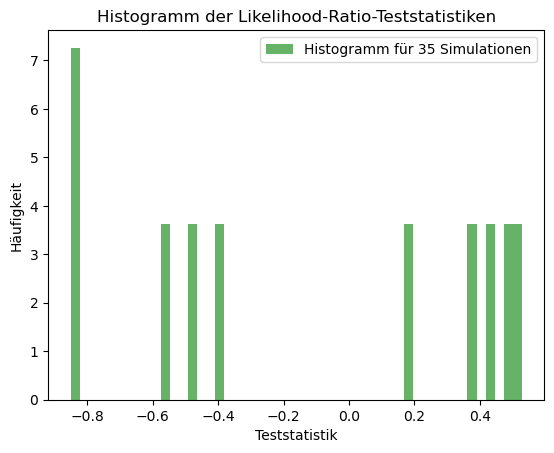

In [114]:
# plot the histogr<am of the LRT-statistic
plt.hist(lrt_results, bins=50, density=True, alpha=0.6, color='g', label='Histogramm für 35 Simulationen')

#x = np.linspace(-8000, 8000, 100)
#plt.plot(x, chi2.pdf(x + 500, df=1), 'r-', lw=2, label='Chi-Quadrat-Verteilung (df=1)')

# Beschriftungen hinzufügen
plt.title('Histogramm der Likelihood-Ratio-Teststatistiken')
plt.xlabel('Teststatistik')
plt.ylabel('Häufigkeit')
plt.legend()

# Histogramm anzeigen
plt.show()